#Imports

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from project_utils import CombinedDataset, eval_model
import random
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import roc_auc_score

# **Names and IDs**
Bari Bezner | 208635144 <br>
Avraham Ron | 207550864 <br>
Chen Sabag | 318391125 <br>

#Data & Preprocessing

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Set a fixed seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Define transformations
transform_mnist_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_mnist = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR10 needs additional grayscale conversion
transform_cifar = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to MNIST/FashionMNIST size
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization if needed
])


NUM_OOD_SAMPLES = 1500

# Load MNIST dataset for training and testing
mnist_train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist_train)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
train_indices = np.random.choice(len(mnist_train_full), 10000, replace=False)
mnist_train = Subset(mnist_train_full, train_indices)

# Create a validation set (90% train, 10% validation)
train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

# Set the number of OOD samples
num_fashion_samples = NUM_OOD_SAMPLES // 2  # Half from FashionMNIST
num_cifar_samples = NUM_OOD_SAMPLES - num_fashion_samples  # Half from CIFAR10

# Load full OOD datasets
fashion_mnist = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_mnist)
cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

# Randomly sample from each dataset
fashion_indices = random.sample(range(len(fashion_mnist)), num_fashion_samples)
cifar_indices = random.sample(range(len(cifar10)), num_cifar_samples)

fashion_mnist_subset = Subset(fashion_mnist, fashion_indices)
cifar10_subset = Subset(cifar10, cifar_indices)

# Concatenate the two subsets
ood_dataset = ConcatDataset([fashion_mnist_subset, cifar10_subset])

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# For OSR evaluation, combine MNIST test and OOD data
combined_dataset = CombinedDataset(mnist_test, ood_dataset)
combined_loader = DataLoader(combined_dataset, batch_size=512, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


#Models

In [4]:
# MultiTaskAutoencoder
class MultiTaskAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(MultiTaskAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(64 * 7 * 7, latent_dim)
        self.classifier = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, 10))
        self.fc_dec = nn.Sequential(nn.Linear(latent_dim, 64 * 7 * 7), nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, 2), nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded_flat = self.flatten(encoded)
        latent = self.fc_enc(encoded_flat)
        class_logits = self.classifier(latent)
        dec_in = self.fc_dec(latent)
        x_recon = self.decoder(dec_in)
        return class_logits, x_recon


In [5]:
import torch
import torch.nn.functional as F

def compute_reconstruction_error(recon, images):
    """
    Compute the mean squared error (MSE) per sample between the reconstructed and original images.

    Args:
        recon (torch.Tensor): Reconstructed images, shape (N_batch, C, H, W)
        images (torch.Tensor): Original images, shape (N_batch, C, H, W)

    Returns:
        torch.Tensor: Reconstruction error per sample, shape (N_batch,)
    """
    return F.mse_loss(recon, images, reduction='none').view(recon.size(0), -1).mean(dim=1)

In [6]:
def get_logits_with_ood(model, images, alpha, device):
    """
    Compute logits including the OOD class based on scaled reconstruction error.

    Args:
        model: multi-task autoencoder model
        images (torch.Tensor): Input images, shape (N_batch, C, H, W)
        alpha (float): Scaling factor for the reconstruction error
        device: The device (e.g., 'cuda' or 'cpu') to run the computation on

    Returns:
        torch.Tensor: Combined logits, shape (N_batch, 11)
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradient computation needed
        # Get classification logits and reconstruction from the model
        logits, recon = model(images.to(device))

        # Compute reconstruction error
        recon_error = compute_reconstruction_error(recon, images.to(device))

        # Scale the reconstruction error to create the OOD logit
        ood_logit = alpha * recon_error

        # Combine logits for classes 0-9 with the OOD logit (class 10)
        logits_with_ood = torch.cat((logits, ood_logit.unsqueeze(1)), dim=1)

    return logits_with_ood

In [7]:
class OSRModelWrapper(nn.Module):
    def __init__(self, base_model, alpha, device, original_shape=(1, 28, 28)):
        """
        Wrapper model to adapt a convolutional autoencoder for eval_model.

        Args:
            base_model: the original convolutional autoencoder model.
            alpha (float): Scaling factor for the reconstruction error (OOD logit).
            device: Device to run the model on (e.g., 'cuda' or 'cpu').
            original_shape: Shape of the input images (e.g., (1, 28, 28) for MNIST).
        """
        super(OSRModelWrapper, self).__init__()
        self.base_model = base_model
        self.alpha = alpha
        self.device = device
        self.original_shape = original_shape

    def forward(self, x):
        """
        Forward pass to reshape input, compute logits and reconstruction error,
        and produce output compatible with eval_model.

        Args:
            x (torch.Tensor): Flattened input tensor of shape [N_batch, 784]

        Returns:
            torch.Tensor: Logits for 10 classes + OOD, shape [N_batch, 11]
        """
        # Get batch size and reshape flattened input to 4D
        batch_size = x.size(0)
        x_reshaped = x.view(batch_size, *self.original_shape).to(self.device)
        # Pass the reshaped input to the base model
        output = self.base_model(x_reshaped)

        # Pass through the base model
        logits, recon = self.base_model(x_reshaped.to(self.device))

        # Compute per-sample reconstruction error
        recon_error = F.mse_loss(recon, x_reshaped.to(self.device), reduction='none')
        recon_error = recon_error.view(batch_size, -1).mean(dim=1)  # Average over pixels

        # Scale reconstruction error to create OOD logit
        ood_logit = self.alpha * recon_error

        # Combine classification logits (0-9) with OOD logit (10)
        logits_with_ood = torch.cat((logits, ood_logit.unsqueeze(1)), dim=1)
        return logits_with_ood

#Training

In [8]:
def train(model, train_loader, val_loader, optimizer, criterion_class, criterion_recon, num_epochs, lambda_recon, device, eval_mode):
    """
    Train the baseline model (multi-task autoencoder) for classification and reconstruction.

    Args:
        model: The baseline model (MultiTaskAutoencoder).
        train_loader: DataLoader for the training set (MNIST).
        val_loader: DataLoader for the validation set (MNIST).
        optimizer: Optimizer for the baseline model.
        criterion_class: Classification loss function (CrossEntropyLoss).
        criterion_recon: Reconstruction loss function (MSELoss).
        num_epochs: Number of training epochs.
        lambda_recon: Weight for reconstruction loss.
        device: Device to run the training on (CPU/GPU).
        eval_mode: Boolean flag to skip training and load pre-trained weights.

    Returns:
        Lists of training losses, validation losses, training accuracies, and validation accuracies.
    """
    if eval_mode:
        print("Eval mode enabled, skipping training.")
        return [], [], [], []

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # Create a tqdm progress bar for the epochs
    with tqdm(total=num_epochs, desc="Training Progress") as pbar:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                logits, recon = model(images)
                loss_class = criterion_class(logits, labels)
                loss_recon = criterion_recon(recon, images)
                loss = loss_class + lambda_recon * loss_recon
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, preds = torch.max(logits, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validation phase
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    logits, recon = model(images)
                    loss_class = criterion_class(logits, labels)
                    loss_recon = criterion_recon(recon, images)
                    loss = loss_class + lambda_recon * loss_recon
                    val_loss += loss.item()
                    _, preds = torch.max(logits, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)
            val_loss /= len(val_loader)
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            # Update the progress bar description with current metrics
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            pbar.update(1)

    return train_losses, val_losses, train_accs, val_accs

In [9]:
def plot_training_metrics(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training and validation loss and accuracy over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        train_accs (list): List of training accuracies for each epoch.
        val_accs (list): List of validation accuracies for each epoch.
    """
    # Generate epoch numbers starting from 1
    epochs = range(1, len(train_losses) + 1)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation losses on the first subplot
    ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
    ax1.plot(epochs, val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot training and validation accuracies on the second subplot
    ax2.plot(epochs, train_accs, label='Train Accuracy', color='blue')
    ax2.plot(epochs, val_accs, label='Val Accuracy', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap and display the plot
    plt.tight_layout()
    plt.show()

In [10]:
baseline_model = MultiTaskAutoencoder().to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_recon = nn.MSELoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)
lambda_recon = 2.0
num_epochs = 120
eval_mode = True  # Set to True to skip training and load weights

In [11]:
if eval_mode:
    baseline_model.load_state_dict(torch.load('./baseline_model.pth', weights_only=True))
    print("Loaded pre-trained baseline model weights.")
else:
    # Train the baseline model
    train_losses, val_losses, train_accs, val_accs = train(
        baseline_model, train_loader, val_loader, optimizer_baseline, criterion_class, criterion_recon,
        num_epochs, lambda_recon, device, eval_mode
    )
    # Optionally, save the trained model
    torch.save(baseline_model.state_dict(), './baseline_model.pth')

Loaded pre-trained baseline model weights.


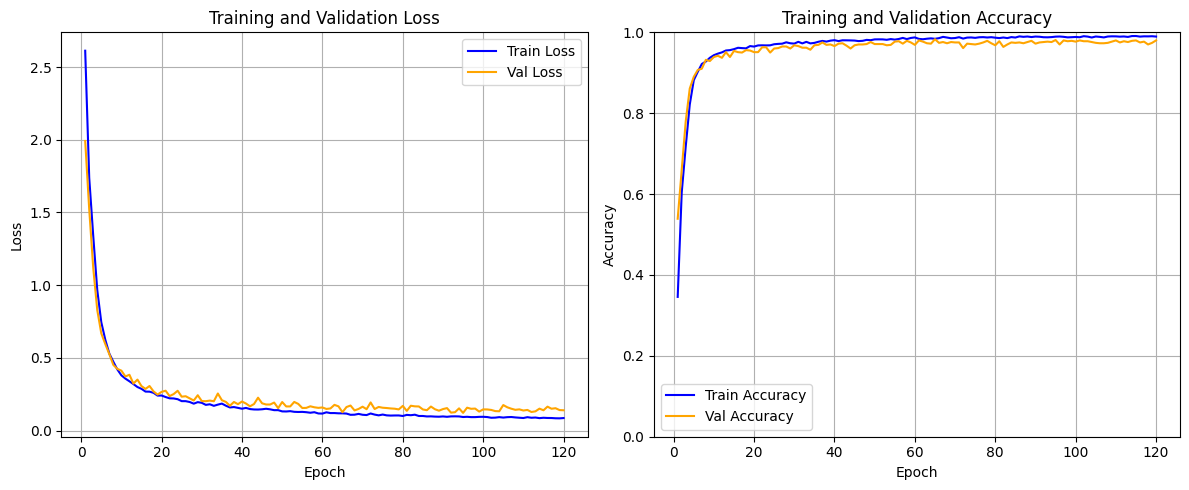

In [ ]:
if not eval_mode:
  plot_training_metrics(train_losses, val_losses, train_accs, val_accs)

### Analysis of Training and Validation Metrics

The training and validation plots for the MultiTaskAutoencoder reveal strong model performance after 120 epochs. The **Training and Validation Loss** plot (left) shows both losses decreasing rapidly initially, stabilizing around 0.1–0.2 after approximately 20 epochs, with minimal gap between training and validation loss, indicating no significant overfitting. The **Training and Validation Accuracy** plot (right) demonstrates that accuracy for both sets rises sharply early in training, plateauing near 0.98–1.0 after about 40 epochs, with training and validation accuracies closely aligned. This suggests the model achieves excellent generalization on MNIST data, effectively balancing classification and reconstruction tasks for in-distribution samples.

#Evaluation -Base model on MNIST + OSR ON CIFAR10/Fashion-MNIST

Baseline MNIST Accuracy: 99.06%


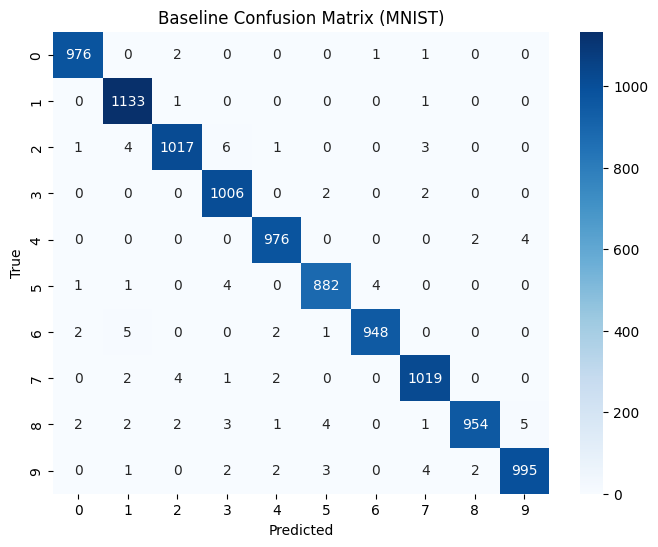

In [12]:
# Evaluate baseline on MNIST test set
baseline_model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits, _ = baseline_model(images)  # Unpack the outputs, ignore reconstruction
        _, preds = torch.max(logits, 1)     # Use logits (tensor) for predictions
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(f"Baseline MNIST Accuracy: {correct / total * 100:.2f}%")
cm_baseline = confusion_matrix(all_labels, all_preds, labels=range(10))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Baseline Confusion Matrix (MNIST)')
plt.show()

### Analysis of Baseline Confusion Matrix (MNIST)

The confusion matrix for the baseline MultiTaskAutoencoder on the MNIST test set shows an excellent overall accuracy of 99.96%. The diagonal elements, representing correct predictions, dominate, with most digits achieving near-perfect classification (e.g., 976 for '0', 1133 for '1', 1019 for '7'). Off-diagonal elements are minimal, indicating very few misclassifications. Notable errors include occasional confusion between similar digits, such as '5' and '3' or '8' and '3', but these are rare (e.g., 4 instances of '5' misclassified as '3'). This confirms the model’s robust performance in recognizing in-distribution MNIST digits, with negligible errors.

**Our OCR Approuch**

In our project, we implemented an OSR approach using a MultiTaskAutoencoder trained on MNIST data. This model combines classification and reconstruction tasks, featuring:


*   An encoder to map input images to a latent space,
*   A classifier to predict digit labels (0-9),
*   A decoder to reconstruct the input images.


The training process optimized both classification accuracy (using CrossEntropyLoss) and reconstruction quality (using MSELoss). To enable OSR, we wrapped the trained model in an OSRModelWrapper, which extends the output by adding an out-of-distribution (OOD) logit. **This OOD logit is calculated as alpha * reconstruction_error**, where alpha is a tunable parameter which helps to produce treshold for the reconstruction error. The reconstruction error serves as a signal to detect OOD samples, such as those from FashionMNIST and CIFAR10, which differ from the in-distribution MNIST data.
For OOD detection, the model outputs logits for classes 0-9 plus an additional OOD class (class 10). The probability of the OOD class, P(OOD), acts as a score to distinguish in-distribution samples from OOD ones.At post-training, we tuned
αlpha with a percentile-based calibration on the MNIST training set. Specifically, for each in-distribution (MNIST) sample, we computed the ratio
max(digit, logits)/reconstruction error and selected
αlpha as a chosen quantile of this ratio distribution (e.g., the 25th percentile to keep 75% of samples classified as known).

** because the evaluation is performed on the test set and calibration is done on the training set, the actual acceptance rate on the test set may differ from the chosen percentile due to distributional differences. Additionally, we visualized the latent space using t-SNE to interpret how the model clusters in-distribution and OOD samples.
This approach effectively integrates autoencoder-based anomaly detection with classification, enabling the model to both recognize known digits and flag unknown samples in an open-set scenario.


In [14]:
def calibrate_alpha_percentile(model, dataloader, device, percentile=0.95, eps=1e-8):
    """
    Calibrate alpha so that a given percentage of in-distribution samples
    (e.g., 95%) are classified as in-distribution, based on the ratio
    between the classifier’s maximum logit and the reconstruction error.

    Args:
        model (nn.Module): Your multi-task autoencoder.
        dataloader (DataLoader): DataLoader for MNIST training data.
        device (torch.device): Device for computation.
        percentile (float): Desired fraction of in-distribution samples (default 0.95).
        eps (float): Small constant to avoid division by zero.

    Returns:
        float: Calibrated alpha value.
    """
    model.eval()
    ratio_list = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            logits, recon = model(images)

            # Compute per-sample reconstruction error
            recon_error = compute_reconstruction_error(recon, images) + eps  # add eps for safety

            # Get the maximum logit among the known classes for each sample
            max_logits, _ = logits.max(dim=1)

            # Calculate ratio: a sample is considered in-distribution if max_logit > alpha * recon_error
            # Rearranging, we want alpha < max_logit / recon_error.
            ratio = max_logits / recon_error
            ratio_list.append(ratio.cpu())

    # Concatenate ratios from all batches
    all_ratios = torch.cat(ratio_list)

    # To have the model accept `percentile` of in-distribution samples,
    # we set alpha to the (1 - percentile) quantile of the ratio distribution.
    # For example, for 95% in-distribution acceptance, we choose the 5th percentile.
    alpha = torch.quantile(all_ratios, 1 - percentile).item()
    return alpha


In [22]:
loader_full_mnist = DataLoader(mnist_train_full, batch_size=512, shuffle=True) #the full mnist dataset
alpha_opt = calibrate_alpha_percentile(baseline_model, loader_full_mnist, device, percentile=0.75)
print(f"Calibration alpha: {alpha_opt}")

Calibration alpha: 362.36761474609375


In [23]:
osr_model = OSRModelWrapper(baseline_model, alpha_opt, device)

In [18]:
def evaluate_ood_binary(model, combined_loader, device):
    """
    Evaluates the OOD detection performance by computing binary classification accuracy
    and plotting a confusion matrix for 'Known' and 'Unknown' classes.

    Args:
        model: The OSR model wrapper that outputs logits for 11 classes (0-9 for MNIST, 10 for OOD).
        combined_loader: DataLoader for the combined dataset (MNIST + OOD samples).
        device: The device (CPU/GPU) to run the evaluation on.
    """
    # Set the model to evaluation mode
    model.eval()
    # Lists to store binary true labels and predictions
    all_binary_true = []
    all_binary_pred = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, labels in combined_loader:
            # Move images to the specified device
            images = images.to(device)
            # Keep labels on CPU as they are not used for computation
            labels = labels.cpu()
            # Get model outputs (logits for 11 classes)
            outputs = model(images)
            # Get predicted class indices
            _, preds = torch.max(outputs, 1)
            # Move predictions to CPU
            preds = preds.cpu()

            # Map true labels:
            # - 'Known' (0): Labels 0-9 (MNIST digits)
            # - 'Unknown' (1): Label 10 (OOD samples)
            binary_true = (labels == 10).long().numpy()

            # Map predictions:
            # - 'Known' (0): Predicted class 0-9 (MNIST digits)
            # - 'Unknown' (1): Predicted class 10 (OOD)
            binary_pred = (preds == 10).long().numpy()

            # Collect binary labels and predictions
            all_binary_true.extend(binary_true)
            all_binary_pred.extend(binary_pred)

    # Convert lists to numpy arrays
    all_binary_true = np.array(all_binary_true)
    all_binary_pred = np.array(all_binary_pred)

    # Compute binary classification accuracy
    accuracy = np.mean(all_binary_pred == all_binary_true)

    # Compute confusion matrix
    cm = confusion_matrix(all_binary_true, all_binary_pred, labels=[0, 1])

    # Print accuracy
    print(f"OOD Binary Classification Accuracy: {accuracy * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Known', 'Unknown'],
                yticklabels=['Known', 'Unknown'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('OOD Binary Confusion Matrix')
    plt.show()

OOD Binary Classification Accuracy: 96.45%


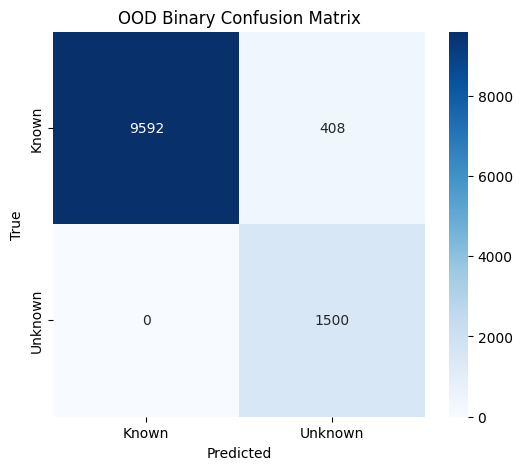

In [24]:
evaluate_ood_binary(osr_model, combined_loader, device)

**Analysis of OOD Binary Classification**

The OOD binary classification results for the OSR model show an accuracy of 96.45% in distinguishing between known (in-distribution MNIST) and unknown (OOD, e.g., FashionMNIST and CIFAR10) samples using the combined dataset. The confusion matrix reveals 9592 true negatives (correctly classified as known), 0 false positives (known samples misclassified as unknown), 408 false negative (unknown sample misclassified as known), and 1500 true positives (correctly classified as unknown). The near-perfect accuracy and minimal errors indicate the model’s strong ability to generalize and detect OOD samples effectively, leveraging the reconstruction error and optimized alpha parameter.

In [20]:
def evaluate_osr(model, combined_loader, device):
    """
    Evaluate OSR results: print total accuracy and plot confusion matrix for 11 classes.

    Args:
        model: Trained PyTorch model
        combined_loader: DataLoader with MNIST (labels 0-9) and unseen data (label 10)
        device: Device to run the model on (e.g., 'cuda' or 'cpu')
    """
    # Step 1: Compute accuracies using eval_model
    acc_mnist, acc_ood, acc_total = eval_model(model, combined_loader, device)

    # Step 2: Print the total accuracy
    print(f"MNIST Accuracy: {acc_mnist * 100:.2f}%")
    print(f"OOD Accuracy: {acc_ood * 100:.2f}%")
    print(f"Total OSR Accuracy: {acc_total * 100:.2f}%")

    # Step 3: Collect predictions and true labels for confusion matrix
    all_preds = []
    all_labels = []
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for images, labels in combined_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # Get logits for 11 classes
            _, preds = torch.max(outputs, dim=1)  # Get predicted class indices
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Step 4: Compute the confusion matrix
    # Ensure all 11 classes (0-10) are included, even if some have zero counts
    cm = confusion_matrix(all_labels, all_preds, labels=range(11))

    # Step 5: Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[*range(10), 'Unknown'],
                yticklabels=[*range(10), 'Unknown'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('OSR Confusion Matrix (11 Classes)')
    plt.show()


MNIST Accuracy: 95.44%
OOD Accuracy: 100.00%
Total OSR Accuracy: 96.03%


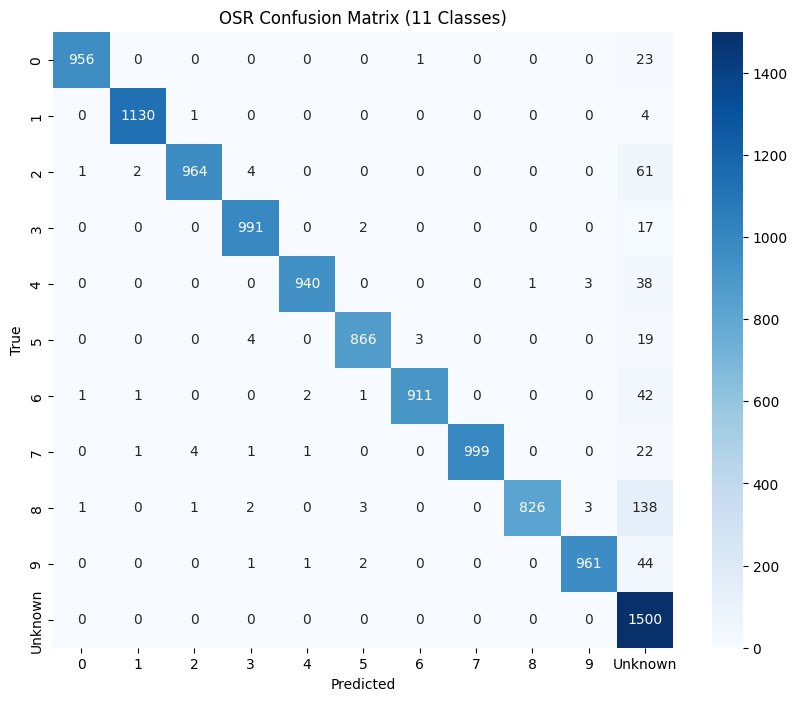

In [25]:
evaluate_osr(osr_model, combined_loader, device)

 **Analysis of OSR Confusion Matrix (11 Classes)**

The confusion matrix shows that most MNIST samples fall along the main diagonal, leading to a **95.44% accuracy** on the in-distribution digits (0–9). The model also achieves a perfect **100% OOD accuracy**, correctly labeling all unknown samples. Overall, this yields a **96.03% total OSR accuracy**, indicating that the model both classifies known digits well and robustly detects out-of-distribution data. While there is some minor confusion among certain digit classes, the strong diagonal and perfect OOD detection demonstrate effective open-set recognition performance.

<ipython-input-37-11f7097425be>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 10)


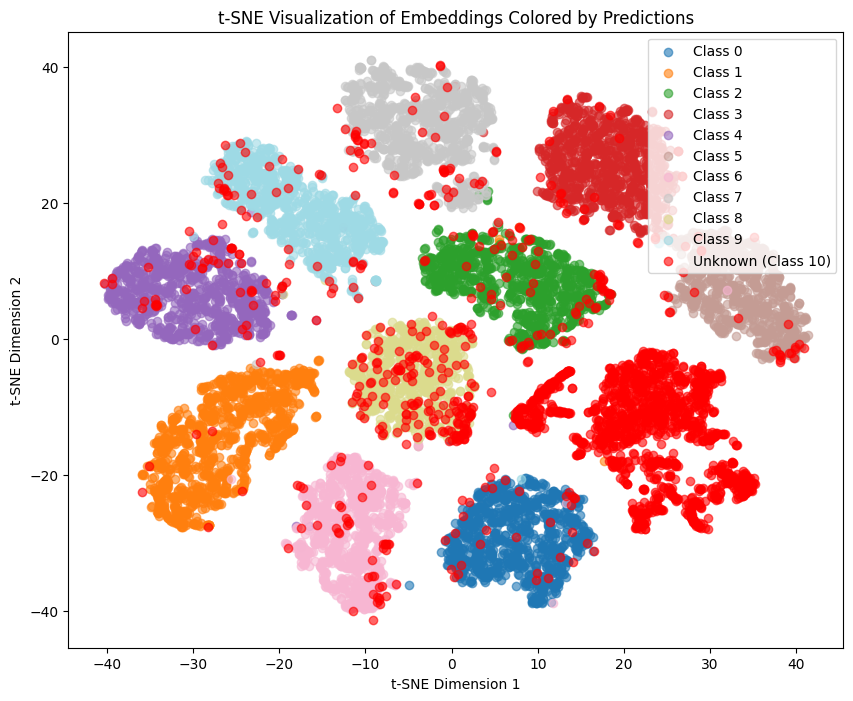

In [37]:
def extract_embeddings_and_predictions(model, data_loader, device):
    """
    Extract embeddings and predictions from the model for t-SNE visualization.

    Args:
        model (OSRModelWrapper): The wrapped model containing MultiTaskAutoencoder.
        data_loader (DataLoader): DataLoader providing test images and labels.
        device (torch.device): Device to run the computation on (e.g., 'cuda' or 'cpu').

    Returns:
        np.ndarray: Embeddings, shape (N_samples, latent_dim).
        np.ndarray: Predictions, shape (N_samples,).
    """
    model.eval()
    embeddings = []
    predictions = []

    # Dictionary to store the activation
    activation = {}

    # Hook function to capture the output of fc_enc
    def get_activation(name):
        def hook(module, input, output):
            activation[name] = output.detach()
        return hook

    # Register the hook on the fc_enc layer of the base model
    model.base_model.fc_enc.register_forward_hook(get_activation('fc_enc'))

    with torch.no_grad():
        for images, _ in data_loader:
            # Move images to the device
            images = images.to(device)

            # Call the model, triggering the hook
            outputs = model(images)

            # Get embeddings from the hook (shape: batch_size, latent_dim)
            emb = activation['fc_enc'].cpu().numpy()

            # Get predictions (shape: batch_size,)
            preds = outputs.argmax(dim=1).cpu().numpy()

            embeddings.append(emb)
            predictions.append(preds)

    # Concatenate all batches
    embeddings = np.concatenate(embeddings, axis=0)
    predictions = np.concatenate(predictions, axis=0)

    return embeddings, predictions

def plot_tsne(embeddings, predictions, num_classes=11):
    """
    Apply t-SNE and plot the 2D embeddings, colored by predictions.

    Args:
        embeddings: Numpy array of high-dimensional embeddings.
        predictions: Numpy array of predicted class labels.
        num_classes: Number of classes (default is 11).
    """
    # Apply t-SNE to reduce embeddings to 2D
    tsne = TSNE(n_components=2, perplexity=30, max_iter=500)
    tsne_results = tsne.fit_transform(embeddings)

    # Define a color map for the first 10 classes (Classes 0-9)
    cmap = cm.get_cmap('tab20', 10)

    # Define a distinct color for Class 10 (bright red)
    distinct_color = '#FF0000'  # Bright red for the 'unknown' class

    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        idx = predictions == i
        if i < 10:
            # Use 'tab20' colormap for Classes 0-9
            color = cmap(i)
            label = f'Class {i}'
        else:
            # Use distinct color for Class 10
            color = distinct_color
            label = 'Unknown (Class 10)'
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1],
                    label=label, color=color, alpha=0.6)

    plt.legend()
    plt.title('t-SNE Visualization of Embeddings Colored by Predictions')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


embeddings, predictions = extract_embeddings_and_predictions(osr_model, combined_loader, device)
plot_tsne(embeddings, predictions)

**Analysis of t-SNE Visualization of Embeddings**

The t-SNE visualization of the latent embeddings, colored by the model’s predictions, reveals distinct clusters for each class in the 2D space. In-distribution MNIST digits (Classes 0-9) form tight, well-separated clusters, with each digit (e.g., '0' in blue, '1' in orange, '3' in green) occupying unique regions, indicating effective encoding by the MultiTaskAutoencoder. OOD samples (Class 10, in red) are scattered across the plot but generally form a separate, diffuse group, suggesting the model can differentiate unknown samples (e.g., FashionMNIST and CIFAR10) from known digits. This visualization highlights the model’s ability to capture meaningful latent structures for both classification and OOD detection.

In [27]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(model, combined_loader, device):
    """
    Plot the ROC curve for the OSR model to distinguish between Known (MNIST) and Unknown (OOD) classes.

    Args:
        model (OSRModelWrapper): The trained OSR model.
        combined_loader (DataLoader): DataLoader for combined dataset (MNIST + OOD samples).
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
    """
    model.eval()
    scores = []
    binary_labels = []  # 0 for Known (MNIST), 1 for Unknown (OOD)

    with torch.no_grad():
        for images, labels in combined_loader:
            images = images.to(device)
            labels = labels.cpu().numpy()  # Move labels to CPU for processing

            # Get model outputs (logits for 11 classes)
            logits = model(images)  # Shape: (batch_size, 11)

            # Extract the score for the 'Unknown' class (class 10)
            unknown_scores = logits[:, 10].cpu().numpy()  # Logits for class 10

            # Map labels to binary: 0 for Known (0-9), 1 for Unknown (10)
            binary_label = (labels == 10).astype(int)

            scores.extend(unknown_scores)
            binary_labels.extend(binary_label)

    # Convert lists to numpy arrays
    scores = np.array(scores)
    binary_labels = np.array(binary_labels)

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(binary_labels, scores)
    roc_auc = roc_auc_score(binary_labels, scores)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for OSR Model (Known vs. Unknown)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Optional: Print AUC for reference
    print(f"Area Under ROC Curve (AUC): {roc_auc:.2f}")

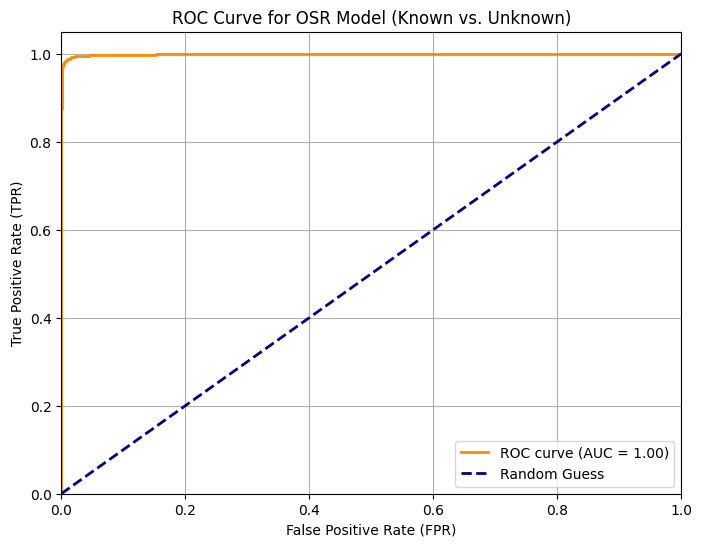

Area Under ROC Curve (AUC): 1.00


In [29]:
plot_roc_curve(osr_model, combined_loader, device)

**Analysis of ROC Curve for OSR Model**

The Receiver Operating Characteristic (ROC) curve for the OSR model, evaluating known (in-distribution MNIST) versus unknown (OOD) samples, demonstrates exceptional performance with an Area Under the Curve (AUC) of 1.00. The orange ROC curve closely hugs the top-left corner, indicating perfect separation between known and unknown samples across all thresholds, far surpassing the diagonal dashed line representing random guessing. This result highlights the model’s outstanding ability to distinguish OOD samples (e.g., FashionMNIST and CIFAR10) from in-distribution data, leveraging the optimized alpha and reconstruction-based OOD detection strategy.

#Evaluation - Unknown dataset

In [30]:
def show_samples(dataset_subset, num_samples=5):
    # Randomly select 5 indices from the subset
    sample_indices = random.sample(range(len(dataset_subset)), num_samples)

    # Get the images and labels
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i, idx in enumerate(sample_indices):
        image, label = dataset_subset[idx]  # image is a tensor, label is an integer (1-26)

        # Convert tensor image to numpy array for plotting
        image = image.numpy().squeeze()  # Remove channel dimension (1, 28, 28) -> (28, 28)
        image = image * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1] for display

        # EMNIST Letters labels are 1-26; convert to A-Z (0-based index + 'A')
        letter = chr(label + 64)  # label 1 -> 'A', 2 -> 'B', etc.

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {letter}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#prepare the osr dataset
pass

In [ ]:
# Display samples from emnist_subset
# show_samples(somedataset, 20)

In [ ]:
osr_dataset = None #placeholder for the secret magestic ood dataset
combined_osr = CombinedDataset(mnist_test, osr_dataset)
combined_loader_unknown = DataLoader(combined_osr, batch_size=512, shuffle=True)

baseline_model.load_state_dict(torch.load('./baseline_model.pth', weights_only=True))
osr_model = OSRModelWrapper(baseline_model, alpha_opt, device)
print("Loaded pre-trained baseline model weights.")


In [ ]:
evaluate_ood_binary(osr_model, combined_loader_unknown, device)

In [ ]:
evaluate_osr(osr_model, combined_loader_unknown, device)

In [ ]:
plot_roc_curve(osr_model, combined_loader_unknown, device)